## TP LeNet5

**LeNet5 est l'un des premiers réseaux de neurones convolutifs (CNN). Il a été proposé par Yann LeCun et d'autres en 1998. Vous pouvez lire l'article original [ici](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) : Gradient-Based Learning Applied to Document Recognition. Dans l'article, le LeNet5 a été utilisé pour la reconnaissance de caractères manuscrits.**

**Comprenons maintenant l'architecture de LeNet5 comme le montre la figure ci-dessous :**

![lenet.png](attachment:lenet.png)

**Comme son nom l'indique, LeNet5 a 5 couches avec deux couches convolutives et trois couches entièrement connectées. Commençons par l'entrée. LeNet5 accepte en entrée une image en niveaux de gris de 32x32, indiquant que l'architecture n'est pas adaptée aux images RVB (canaux multiples). L'image d'entrée ne doit donc contenir qu'un seul canal.**

**La première couche convolutive a une taille de filtre de 5x5 avec 6 de ces filtres. Cela réduira la largeur et la hauteur de l'image tout en augmentant la profondeur (nombre de canaux). La sortie serait 28x28x6. Après cela, la mise en commun est appliquée pour réduire de moitié la carte des fonctionnalités, c'est-à-dire 14x14x6. La même taille de filtre (5x5) avec 16 filtres est maintenant appliquée à la sortie suivie d'une couche de regroupement. Cela réduit la carte des fonctionnalités de sortie à 5x5x16.**

**Après cela, une couche convolutive de taille 5x5 avec 120 filtres est appliquée pour aplatir la carte des caractéristiques à 120 valeurs. Vient ensuite la première couche entièrement connectée, avec 84 neurones. Enfin, nous avons la couche de sortie qui a 10 neurones de sortie, puisque les données MNIST ont 10 classes pour chacun des 10 chiffres numériques représentés.**

## Data Loading
# Dataset

**Commençons par charger et analyser les données. Nous utiliserons le jeu de données MNIST. Le jeu de données MNIST contient des images de chiffres numériques manuscrits. Les images sont en niveaux de gris, toutes d'une taille de 28x28, et sont composées de 60 000 images d'entraînement et de 10 000 images de test.**

**Vous pouvez voir quelques-uns des exemples d'images ci-dessous :**

![min.png](attachment:min.png)

## Importation des librairies

In [ ]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import matplotlib.pyplot as plt

def plot_history(train_loss_h):
    plt.figure(figsize=(10,10))
    plt.subplot(2, 1, 1)
    plt.plot(train_loss_h, label='train')
    plt.legend()
    plt.title('Loss')
    plt.show()

## Chargement de la dataset

**À l'aide de torchvision , nous chargerons l'ensemble de données car cela nous permettra d'effectuer facilement toutes les étapes de prétraitement.**

In [ ]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

Comprenons le code :

- Premièrement, les données MNIST ne peuvent pas être utilisées telles quelles pour l'architecture LeNet5. L'architecture LeNet5 accepte l'entrée en 32x32 et les images MNIST sont en 28x28. Nous pouvons résoudre ce problème en redimensionnant les images, en les normalisant à l'aide de la moyenne et de l'écart type précalculés, et enfin en les stockant sous forme de tenseurs. 


- Nous définissons download=True si les données ne sont pas déjà téléchargées. 


- Ensuite, nous utilisons les dataloader. Les chargeurs de données nous permettent d'itérer les données par lots, et les données sont chargées pendant l'itération et non immédiatement au démarrage. 


- Nous spécifions la taille du lot "batch size" et mélangeons l'ensemble de données lors du chargement afin que chaque lot ait une certaine variation dans les types d'étiquettes dont il dispose. Cela augmentera l'efficacité de notre modèle.

In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

Je vais expliquer le code linéairement:

 - Dans PyTorch, nous définissons un réseau de neurones en créant une classe qui hérite de nn.Module car elle contient de nombreuses méthodes que nous devrons utiliser.
 
 
 - Il y a deux étapes principales après cela. La première consiste à initialiser les couches que nous allons utiliser dans notre CNN à l'intérieur de __init__ , et l'autre consiste à définir la séquence dans laquelle ces couches traiteront l'image. Ceci est défini dans la fonction forward.
 
- Pour l'architecture elle-même, nous définissons d'abord les couches convolutives à l'aide de la fonction nn.Conv2D avec la taille de noyau appropriée et les canaux d'entrée/sortie. Nous appliquons également la mise en commun maximale à l'aide de la fonction nn.MaxPool2D. La bonne chose à propos de PyTorch est que nous pouvons combiner la couche convolutive, la fonction d'activation et la mise en commun maximale en une seule couche (elles seront appliquées séparément, mais cela aide à l'organisation) en utilisant la fonction nn.Sequential.


- Ensuite, nous définissons les couches entièrement connectées. Notez que nous pouvons également utiliser nn.Sequential ici et combiner les fonctions d'activation et les couches linéaires, mais je voulais montrer que l'une ou l'autre est possible.


- Enfin, notre dernière couche produit 10 neurones qui sont nos prédictions finales pour les chiffres.

## Définition des hyperparamètres


**Avant la formation, nous devons définir certains hyperparamètres, tels que la fonction de perte et l'optimiseur à utiliser.**

In [ ]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)


**Nous commençons par initialiser notre modèle en utilisant le nombre de classes comme argument, qui dans ce cas est 10. Ensuite, nous définissons notre fonction de coût comme perte d'entropie croisée et optimiseur comme Adam. Il y a beaucoup de choix pour ceux-ci, mais ceux-ci ont tendance à donner de bons résultats avec le modèle et les données fournies. Enfin, nous définissons total_step pour mieux suivre les étapes lors de l'entraînement.**

In [ ]:
total_step = len(train_loader)
train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

Epoch [1/10], Step [400/938], Loss: 0.1903
Epoch [1/10], Step [800/938], Loss: 0.0672
Epoch [2/10], Step [400/938], Loss: 0.0931
Epoch [2/10], Step [800/938], Loss: 0.0556
Epoch [3/10], Step [400/938], Loss: 0.1512
Epoch [3/10], Step [800/938], Loss: 0.0939
Epoch [4/10], Step [400/938], Loss: 0.2628
Epoch [4/10], Step [800/938], Loss: 0.2548
Epoch [5/10], Step [400/938], Loss: 0.0106
Epoch [5/10], Step [800/938], Loss: 0.1784
Epoch [6/10], Step [400/938], Loss: 0.1129
Epoch [6/10], Step [800/938], Loss: 0.0500
Epoch [7/10], Step [400/938], Loss: 0.1557
Epoch [7/10], Step [800/938], Loss: 0.0928
Epoch [8/10], Step [400/938], Loss: 0.0395
Epoch [8/10], Step [800/938], Loss: 0.0864
Epoch [9/10], Step [400/938], Loss: 0.0721
Epoch [9/10], Step [800/938], Loss: 0.0643
Epoch [10/10], Step [400/938], Loss: 0.1515
Epoch [10/10], Step [800/938], Loss: 0.0210


TypeError: ignored

**Voyons ce que fait le code :**

- Nous commençons par parcourir le nombre d'époques, puis les lots (batch) dans nos données d'apprentissage.


- Nous mettons les images et les étiquettes sur le GPU.


- Dans le forward, nous faisons des prédictions à l'aide de notre modèle et calculons la perte en fonction de ces prédictions et de nos étiquettes réelles.


- Ensuite, nous effectuons le backward où nous mettons à jour nos poids pour améliorer notre modèle


- Nous mettons ensuite les gradients à zéro avant chaque mise à jour à l'aide de la fonction optimiser.zero_grad().


 - Ensuite, nous calculons les nouveaux gradients à l'aide de la fonction loss.backward().


- Et enfin, nous mettons à jour les poids avec la fonction optimiser.step().

**Comme nous pouvons le voir, la perte diminue à chaque époque, ce qui montre que notre modèle apprend effectivement. Notez que cette perte est sur l'ensemble d'entraînement, et si la perte est trop faible (comme c'est le cas dans notre cas), cela peut indiquer un sur-apprentissage.**

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
	 

Accuracy of the network on the 10000 test images: 98.89 %


## Travail futur 1

Bien que cela semble une très bonne introduction à l'apprentissage en profondeur dans PyTorch, vous devez étendre ce travail :

- Vous pouvez essayer d'utiliser différents ensembles de données, mais pour ce modèle, vous aurez besoin d'ensembles de données en niveaux de gris. L'un de ces ensembles de données est FashionMNIST.


- Vous pouvez expérimenter différents hyperparamètres et voir la meilleure combinaison d'entre eux pour le modèle.


- Vous pouvez essayer d'ajouter ou de supprimer des couches du jeu de données pour voir leur impact sur la capacité du modèle. 


- Enfin vous pouvez également utilisé le [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) pour régulariser le model afin d'éviter le sur apprentissage.



### Dataset FashionMNIST + LeNet with Sigmoid

In [ ]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.FashionMNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.FashionMNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(120, 84)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        out = self.fc2(out)
        return out

In [ ]:
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [ ]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# add decay

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [ ]:
total_step = len(train_loader)
train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

Epoch [1/10], Step [400/938], Loss: 0.8157
Epoch [1/10], Step [800/938], Loss: 0.5804
Epoch [2/10], Step [400/938], Loss: 0.5545
Epoch [2/10], Step [800/938], Loss: 0.5784
Epoch [3/10], Step [400/938], Loss: 0.5511
Epoch [3/10], Step [800/938], Loss: 0.4924
Epoch [4/10], Step [400/938], Loss: 0.4712
Epoch [4/10], Step [800/938], Loss: 0.3925
Epoch [5/10], Step [400/938], Loss: 0.3623
Epoch [5/10], Step [800/938], Loss: 0.3293
Epoch [6/10], Step [400/938], Loss: 0.5459
Epoch [6/10], Step [800/938], Loss: 0.2559
Epoch [7/10], Step [400/938], Loss: 0.2764
Epoch [7/10], Step [800/938], Loss: 0.4542
Epoch [8/10], Step [400/938], Loss: 0.3763
Epoch [8/10], Step [800/938], Loss: 0.3978
Epoch [9/10], Step [400/938], Loss: 0.3181
Epoch [9/10], Step [800/938], Loss: 0.2972
Epoch [10/10], Step [400/938], Loss: 0.1773
Epoch [10/10], Step [800/938], Loss: 0.1570


In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 88.4 %


Le réseau LeNet originel utilisait des sigmoid comme fonction d'activation donc j'ai voulus voir la différence de performance entre les fonctions Sigmoid et ReLU. 

On peut constater un score de 88.4% sur ce nouveau dataset. 

### Minibatch : 64 -> 256

In [ ]:
batch_size = 256
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [ ]:
total_step = len(train_loader)
train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

Epoch [1/10], Step [400/938], Loss: 0.2577
Epoch [1/10], Step [800/938], Loss: 0.2446
Epoch [2/10], Step [400/938], Loss: 0.2568
Epoch [2/10], Step [800/938], Loss: 0.2982
Epoch [3/10], Step [400/938], Loss: 0.3572
Epoch [3/10], Step [800/938], Loss: 0.2069
Epoch [4/10], Step [400/938], Loss: 0.1270
Epoch [4/10], Step [800/938], Loss: 0.1066
Epoch [5/10], Step [400/938], Loss: 0.1870
Epoch [5/10], Step [800/938], Loss: 0.2521
Epoch [6/10], Step [400/938], Loss: 0.1738
Epoch [6/10], Step [800/938], Loss: 0.2138
Epoch [7/10], Step [400/938], Loss: 0.3357
Epoch [7/10], Step [800/938], Loss: 0.0882
Epoch [8/10], Step [400/938], Loss: 0.2463
Epoch [8/10], Step [800/938], Loss: 0.4079
Epoch [9/10], Step [400/938], Loss: 0.1770
Epoch [9/10], Step [800/938], Loss: 0.2098
Epoch [10/10], Step [400/938], Loss: 0.2382
Epoch [10/10], Step [800/938], Loss: 0.1410


In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 90.05 %


La réglage de minibatch de 64 item à 256 apporte un gain de 1.6% sur la précision du modèle. 

### LeNet - Sigmoid -> ReLU

In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# add decay

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [ ]:
batch_size = 256
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [ ]:
total_step = len(train_loader)
train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

Epoch [1/10], Step [400/938], Loss: 0.4297
Epoch [1/10], Step [800/938], Loss: 0.3505
Epoch [2/10], Step [400/938], Loss: 0.2616
Epoch [2/10], Step [800/938], Loss: 0.2705
Epoch [3/10], Step [400/938], Loss: 0.2988
Epoch [3/10], Step [800/938], Loss: 0.2190
Epoch [4/10], Step [400/938], Loss: 0.2146
Epoch [4/10], Step [800/938], Loss: 0.1490
Epoch [5/10], Step [400/938], Loss: 0.3167
Epoch [5/10], Step [800/938], Loss: 0.2078
Epoch [6/10], Step [400/938], Loss: 0.2348
Epoch [6/10], Step [800/938], Loss: 0.2058
Epoch [7/10], Step [400/938], Loss: 0.1361
Epoch [7/10], Step [800/938], Loss: 0.1726
Epoch [8/10], Step [400/938], Loss: 0.1704
Epoch [8/10], Step [800/938], Loss: 0.1966
Epoch [9/10], Step [400/938], Loss: 0.1509
Epoch [9/10], Step [800/938], Loss: 0.1601
Epoch [10/10], Step [400/938], Loss: 0.1614
Epoch [10/10], Step [800/938], Loss: 0.2832


In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 90.13 %


Le changement de l'architecture pour remplacer les fonctions d'activation Sigmoid par des ReLU permet de gagner 0.1% de précision.

### LeNet ReLU + dropout .65

In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.dropout = nn.Dropout(p = 0.65)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.dropout1 = nn.Dropout(p = 0.65)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# add decay

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [ ]:
batch_size = 256
num_classes = 10
learning_rate = 0.001
num_epochs = 10

In [ ]:
total_step = len(train_loader)
train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

Epoch [1/10], Step [400/938], Loss: 0.7275
Epoch [1/10], Step [800/938], Loss: 0.5348
Epoch [2/10], Step [400/938], Loss: 0.5467
Epoch [2/10], Step [800/938], Loss: 0.4629
Epoch [3/10], Step [400/938], Loss: 0.6718
Epoch [3/10], Step [800/938], Loss: 0.5226
Epoch [4/10], Step [400/938], Loss: 0.6368
Epoch [4/10], Step [800/938], Loss: 0.4082
Epoch [5/10], Step [400/938], Loss: 0.3245
Epoch [5/10], Step [800/938], Loss: 0.3632
Epoch [6/10], Step [400/938], Loss: 0.5432
Epoch [6/10], Step [800/938], Loss: 0.4005
Epoch [7/10], Step [400/938], Loss: 0.3526
Epoch [7/10], Step [800/938], Loss: 0.4422
Epoch [8/10], Step [400/938], Loss: 0.3475
Epoch [8/10], Step [800/938], Loss: 0.4006
Epoch [9/10], Step [400/938], Loss: 0.2053
Epoch [9/10], Step [800/938], Loss: 0.3428
Epoch [10/10], Step [400/938], Loss: 0.6596
Epoch [10/10], Step [800/938], Loss: 0.5258


In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 88.73 %


L'utilisation de Dropout avec un ratio de .65 nous fait perdre en précision, c'est le moment d'itérer autour de ce paramètre pour voir comment l'optimiser.

### LeNet ReLU + dropout .45

In [ ]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.dropout = nn.Dropout(p = 0.45)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.dropout1 = nn.Dropout(p = 0.45)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# add decay

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [ ]:
batch_size = 256
num_classes = 10
learning_rate = 0.001
num_epochs = 10

Epoch [1/10], Step [400/938], Loss: 0.2552
Epoch [1/10], Step [800/938], Loss: 0.3882
Epoch [2/10], Step [400/938], Loss: 0.4417
Epoch [2/10], Step [800/938], Loss: 0.2701
Epoch [3/10], Step [400/938], Loss: 0.2737
Epoch [3/10], Step [800/938], Loss: 0.3097
Epoch [4/10], Step [400/938], Loss: 0.2102
Epoch [4/10], Step [800/938], Loss: 0.2359
Epoch [5/10], Step [400/938], Loss: 0.2282
Epoch [5/10], Step [800/938], Loss: 0.2373
Epoch [6/10], Step [400/938], Loss: 0.1976
Epoch [6/10], Step [800/938], Loss: 0.2393
Epoch [7/10], Step [400/938], Loss: 0.3166
Epoch [7/10], Step [800/938], Loss: 0.3469
Epoch [8/10], Step [400/938], Loss: 0.1891
Epoch [8/10], Step [800/938], Loss: 0.1523
Epoch [9/10], Step [400/938], Loss: 0.2728
Epoch [9/10], Step [800/938], Loss: 0.2586
Epoch [10/10], Step [400/938], Loss: 0.1975
Epoch [10/10], Step [800/938], Loss: 0.2920


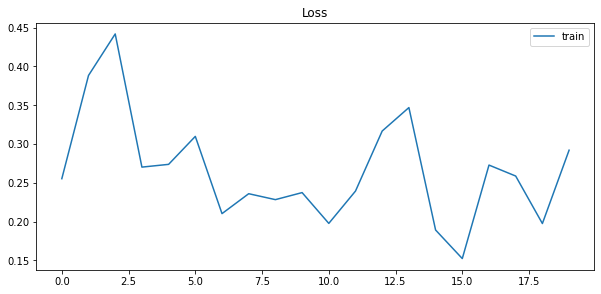

In [ ]:
total_step = len(train_loader)
train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 89.79 %


L'utilisation de Dropout avec un ratio de .65 nous fait perdre en précision, c'est le moment d'itérer autour de ce paramètre pour voir comment l'optimiser.

### LeNet + dropout .35

## Travail futur 2

Le travail 2 consiste à implémenter une nouvelle architecture tel que [Resnet](https://pytorch.org/hub/pytorch_vision_resnet/) ou [AlexNet](https://pytorch.org/hub/pytorch_vision_alexnet/), pour cela vous devez m'expliquer tous les points suivant:

- L'architecture utilisée sous forme de schéma avec quelque explication ainsi que le lien du papier dans lequel elle a été publié (vous pouvez suivre la même organisation que le Tp).


- La Dataset que vous utiliser ainsi que les différentes transformations appliquées.


-  Les hyperparamètres utilisées.


- M'expliquer comment vous avez évalué votre méthode (test dataset).


## Consigne rendue et notation

- Vous devez répondre à tous les points demandés, si un point n'est pas traité alors il y aura une pénalité sur la note.


- Le code rendu doit être claire et bien commenté. 


- Vous pouvez utiliser du code déjà implémenter mais vous devez me donner le lien du ghit/biblio. et bien commenter son code. Tout plagia sans citation entrainera un zéro.


- Le travail rendu en retard entrainera des penalties de 1 point par jour de retard.


- Vous devez répondre à tous les points demandés, si un point n'est pas traité alors il y aura une pénalité sur la note.



- Le code rendu doit être clair et bien commenté. 


- Vous pouvez utiliser du code déjà implémenter mais vous devez me donner le lien du ghit/biblio. et bien commenter son code. Tout plagia sans citation entrainera un zéro.


-  Le travail rendu en retard entrainera des penaltiés de 1 point par jour de retard.


### Présentation de l'architecture utilisé

In [ ]:
# L'architecture utilisée sous forme de schéma avec quelque explication + lien du papier dans lequel elle a été publié
# (vous pouvez suivre la même organisation que le Tp).

L'architecture ResNet à été [publié en décembre 2015 par Kaiming He, Xiangyu Zhang, Shaoqing Ren et Jian Sun de Microsoft Research](https://arxiv.org/abs/1512.03385).

Cette architecture est l'une des plus cités des dernières années et se veut comme une percée dans la reconnaissance d'image (en couleur) par réseaux de neuronnes profonds. 

Comparaison entre ResNet et la génération que ce modèle remplace (VGG-19) et améliore considérablement sa performance. 

![Comparaison architecture VGG-19 & ResNet34 sur le dataset ImageNet](https://miro.medium.com/max/512/1*kBlZtheCjJiA3F1e0IurCw.png)

###

**La première couche convolutive a une taille de filtre de 5x5 avec 6 de ces filtres. Cela réduira la largeur et la hauteur de l'image tout en augmentant la profondeur (nombre de canaux). La sortie serait 28x28x6. Après cela, la mise en commun est appliquée pour réduire de moitié la carte des fonctionnalités, c'est-à-dire 14x14x6. La même taille de filtre (5x5) avec 16 filtres est maintenant appliquée à la sortie suivie d'une couche de regroupement. Cela réduit la carte des fonctionnalités de sortie à 5x5x16.**

**Après cela, une couche convolutive de taille 5x5 avec 120 filtres est appliquée pour aplatir la carte des caractéristiques à 120 valeurs. Vient ensuite la première couche entièrement connectée, avec 84 neurones. Enfin, nous avons la couche de sortie qui a 10 neurones de sortie, puisque les données MNIST ont 10 classes pour chacun des 10 chiffres numériques représentés.**

###

input

conv1 - 1 couche
Conv2D -> in_channels / out_channels=112*112 / kernel_size=7*7 / stride=2

conv2_x - 3 couches (ResNet18 = 2 couches)
MaxPool -> kernel_size 3x3 / strid=2
Conv2D -> in_channels / out_channels=56*56 / kernel_size=1*1 / stride=2
Conv2D -> in_channels / out_channels=56*56 / kernel_size / stride=2
Conv2D -> in_channels / out_channels=56*56 / kernel_size / stride=2

conv3_x - 8 couches (ResNet18 = 2 couches)
Conv2D -> in_channels / out_channels=28*28 / kernel_size / stride

conv4_x - 36 couches (ResNet18 = 2 couches)
Conv2D -> in_channels / out_channels=14*14 / kernel_size / stride

conv5_x - 3 couches (ResNet18 = 2 couches)
Conv2D -> in_channels / out_channels=7*7 / kernel_size / stride

output


### 

À partir du modèle AlexNet, les réseaux de neuronnes profonds s'amélioraient d'un point de vue performances en empilant les couches de convolution les unes au-dessus des autres depuis plusieurs années. 

Les auteurs se sont demandés si la construction d'un meilleur réseaux de neuronnes pouvait se résumer à simplement rajouter plus de couches à un modèle existant. Il s'avère que cette approche n'est pas entièrement exact car elle entraine les problèmes suivants :
- Le réseau devient difficile à optimiser ;
- Les gradients "s'évanouissent" ou "explosent" ;
- La précision du modèle sature ou se dégrade.

> Voir papier pour détails

Pour résoudre ces problèmes, les auteurs ont réfléchis à une architecture avec l'idée de "sauter" certaines connection afin de maximiser la généralisation de l'apprentissage. 

En partant de l'hypothèse que les couches les plus profondes doivent apprendre d'autres motifs que les couches les moins profondes ils sont arrivés à une astuce. 

Dans le schéma précédent on peut voir que sur le réseau "34-layer residual", des flèches permettent de "sauter" certaines couches. On y applique ainsi la logique suivante :

![diagram - skip connection](https://cdn-images-1.medium.com/max/987/1*pUyst_ciesOz_LUg0HocYg.png)

> [Voir source suivante pour plus de détails](https://www.kaggle.com/code/shivamb/cnn-architectures-vgg-resnet-inception-tl/notebook#1.4-Resnets)

Cette solution permet la construction d'un réseau de n'importe quelle profondeur en partant de l'hypothèse que les nouvelles couches vont permettre d'aider à extraire de nouveaux motifs au sein des données. Les auteurs ont permis de construire des réseaux de neuronnes profond de 152. 

Les variants de leur architectures sont les suivants : ResNet34, ResNet50 et ResNet101 qui ont tous profont des solutions avec une haute précision sur les compétitions (notamment ImageNet)



### Présentation du dataset ainsi que les transformations utilisés

#### Expérimentation sur un modèle non pré-entrainé - Solution abandonné

J'ai ici télécharger le modèle ResNet18 depuis le site de PyTorch. [Le lien est trouvable ici](https://pytorch.org/hub/pytorch_vision_resnet/)

[Le dataset utilisé est le suivant : CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)

J'ai fais quelques recherches pour voir différentes manières d'implémenter ResNet en étudiant quelques repos Github :
- [kuangliu/pytorch-cifar](https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py)
- [rwightman/pytorch-image-models](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/resnet.py)
- [Lornatang/ResNet-PyTorch](https://github.com/Lornatang/ResNet-PyTorch)
- [MadryLab/pytorch-example-imagenet](https://github.com/MadryLab/pytorch-example-imagenet)

Ci-dessous un premier essai pour étudier l'architecture et voir ses performances (18 couches). 
J'ai décidé suite à cet essai de m'intéresser au transfer learning et de prendre le ResNet50 pour l'entraîner sur un autre dataset. 


In [ ]:
import matplotlib.pyplot as plt

def plot_history(train_loss_h):
    plt.figure(figsize=(10,10))
    plt.subplot(2, 1, 1)
    plt.plot(train_loss_h, label='train')
    plt.legend()
    plt.title('Loss')
    plt.show()

In [ ]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Resize((64, 64))
])

batch_size = 256

train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=img_transform)
test_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=img_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# num_classes = 10
learning_rate = 0.001

In [ ]:
#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# add decay

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

Epoch [1/50], Step [196/196], Loss: 0.1093
Epoch [2/50], Step [196/196], Loss: 0.0660
Epoch [3/50], Step [196/196], Loss: 0.0052
Epoch [4/50], Step [196/196], Loss: 0.0113
Epoch [5/50], Step [196/196], Loss: 0.0953
Epoch [6/50], Step [196/196], Loss: 0.0472
Epoch [7/50], Step [196/196], Loss: 0.0058
Epoch [8/50], Step [196/196], Loss: 0.0093
Epoch [9/50], Step [196/196], Loss: 0.0013
Epoch [10/50], Step [196/196], Loss: 0.0880
Epoch [11/50], Step [196/196], Loss: 0.0112
Epoch [12/50], Step [196/196], Loss: 0.0480
Epoch [13/50], Step [196/196], Loss: 0.0165
Epoch [14/50], Step [196/196], Loss: 0.0061
Epoch [15/50], Step [196/196], Loss: 0.0008
Epoch [16/50], Step [196/196], Loss: 0.0001
Epoch [17/50], Step [196/196], Loss: 0.0022
Epoch [18/50], Step [196/196], Loss: 0.0352
Epoch [19/50], Step [196/196], Loss: 0.0876
Epoch [20/50], Step [196/196], Loss: 0.0103
Epoch [21/50], Step [196/196], Loss: 0.0111
Epoch [22/50], Step [196/196], Loss: 0.0027
Epoch [23/50], Step [196/196], Loss: 0.00

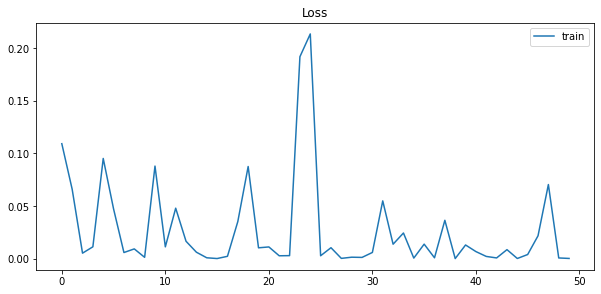

In [ ]:
num_epochs = 50

train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % total_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 86.54 %


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [1/50], Step [196/196], Loss: 6.9588
Epoch [2/50], Step [196/196], Loss: 6.8711
Epoch [3/50], Step [196/196], Loss: 6.8752
Epoch [4/50], Step [196/196], Loss: 6.8597
Epoch [5/50], Step [196/196], Loss: 6.9418
Epoch [6/50], Step [196/196], Loss: 6.7500
Epoch [7/50], Step [196/196], Loss: 6.9293
Epoch [8/50], Step [196/196], Loss: 6.8917
Epoch [9/50], Step [196/196], Loss: 6.8790
Epoch [10/50], Step [196/196], Loss: 7.0450
Epoch [11/50], Step [196/196], Loss: 6.8616
Epoch [12/50], Step [196/196], Loss: 6.8797
Epoch [13/50], Step [196/196], Loss: 6.7427
Epoch [14/50], Step [196/196], Loss: 6.7851
Epoch [15/50], Step [196/196], Loss: 6.8651
Epoch [16/50], Step [196/196], Loss: 6.8796
Epoch [17/50], Step [196/196], Loss: 6.9150
Epoch [18/50], Step [196/196], Loss: 6.9195
Epoch [19/50], Step [196/196], Loss: 6.9488
Epoch [20/50], Step [196/196], Loss: 6.8805
Epoch [21/50], Step [196/196], Loss: 6.9448
Epoch [22/50], Step [196/196], Loss: 6.8038
Epoch [23/50], Step [196/196], Loss: 6.98

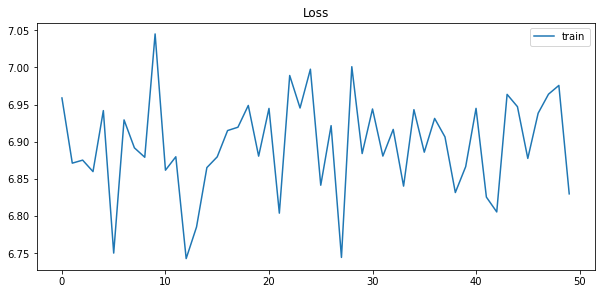

In [ ]:
num_epochs = 50

train_loss_h = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % total_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            train_loss_h.append(loss.item())

plot_history(train_loss_h)

In [ ]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 0.23 %


---

On peut voir que malgré l'architecture, un modèle entrainé va avoir une accuracy élevé (86.54 %) tandis qu'un modèle non-paramétré n'arrivera à aucun résultat (accuracy : 0.24%). 

#### Transfer learning ResNet 50 sur un nouveau dataset - accuracy supérieur à 90%

Je souhaitais découvrir le fonctionnement du transfer learning donc j'ai décidé de télécharger un dataset et suivre ce qu'avait fait data-scientist plus expérimenté sur ce dernier. 

L'article trouvé : https://mlwhiz.com/blog/2020/06/06/multiclass_image_classification_pytorch/ 

J'ai téléchargé le dataset suivant : https://www.kaggle.com/datasets/clorichel/boat-types-recognition 

J'ai refactoré une partie du code pour simplifier ce dernier et avoir de grosses fonctions et plus uniquement une montagne de code dans un style impératif. J'utilise aussi la convention `f'{variable}'` pour gérer mes types string avec certaines variables. 

##### Découverte des données et construction des datasets

In [ ]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models

import torch.nn as nn
#from torchsummary import summary
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
from torch import Tensor, nn
from torch.nn.functional import interpolate

In [ ]:
import torch
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob

import numpy as np
import tqdm

from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image

from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

J'ai décidé d'effectuer tous mes cours de deep learning sur Google collab:
- j'utilise ma machine Collab comme un tampon,
- les sources de données et résultats sont lis et écrit dans Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/'

Les données sont lu depuis un dossier 'data/images'
Les résultats seront écris dans un dossier 'data/outputs'

Ci-dessous l'implémentation d'une fonction qui prendre en entrée une image et effectue les transformation nécessaire pour l'afficher mais aussi retourner un vecteur pytorch (tensor) afin de l'utiliser (étape de transformation, étape de prédiction ainsi que lors de l'évaluation des performances de l'algorithme). 

In [ ]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

Les deux cellules permettent de construire le dataframe utilisé pour déterminer l'emplacement des images, la classe (catégorie de bateau) ainsi que leur dataset respectif (train/test/validation). 

In [ ]:
categories = glob(f'{DATA_PATH}data/images/*')
categories

['/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/paper boat',
 '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/boats',
 '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/inflatable boat',
 '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/buoy',
 '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/gondola',
 '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/ferry boat',
 '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/kayak',
 '/content/gdrive/MyDrive/Colab Notebooks/Ynov - Deep learning/Semaine 1 - CNN + RL - Keras + Pytorch/data/images/cruise ship

In [ ]:
filedf = pd.DataFrame()
for cat in categories:
    files = glob(cat+"/*")
    tempdf = pd.DataFrame({ 'filepath': files, 'category': cat.split("/")[-1] })
    filedf = pd.concat([filedf,tempdf])

print(filedf.shape)
display(filedf.head())

(1471, 2)


,filepath,category
0,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,paper boat
1,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,paper boat
2,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,paper boat
3,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,paper boat
4,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,paper boat


Calcul des répartitions des différentes classes. On peut se rendre compte que notre dataset à tendance à être populer par 4 types d'individues : sailboat, kayak, gondola et cruise ship. Les autres classes auront donc tendance à être moins bien représenté. 

Dans le cas d'un algorithme déployé en production on accordera une attention particulière à construire un dataset "bien équilibré". 

In [ ]:
gby_cnt = filedf.groupby("category").aggregate('count').rename(columns = {'filepath':'cnt'}).reset_index().sort_values(by='cnt',ascending=False)
gby_cnt.to_csv(f"{DATA_PATH}data/outputs/category_counts.csv", index=None)

focus_cats = gby_cnt[gby_cnt['cnt'] >=40]['category'].values
filedf.category.value_counts()

sailboat           488
kayak              254
gondola            242
cruise ship        239
ferry boat          81
buoy                68
paper boat          40
freight boat        29
inflatable boat     21
boats                9
Name: category, dtype: int64

1. Construction des datasets d'entrainement et tests.
2. Construction des différents dossier temporaire utilisé pour stocker les données depuis la machine. 

In [ ]:
X_train, X_test, _, _ = train_test_split(
        filedf, filedf['category'],stratify=filedf['category'], test_size=0.4)

X_test, X_val, _, _ = train_test_split(
        X_test, X_test['category'], stratify=X_test['category'], test_size=0.5)

X_train['type'] = 'train'
X_val['type'] = 'val'
X_test['type'] = 'test'

fulldf = pd.concat([X_train, X_test, X_val])
fulldf['type'].value_counts()

!mkdir data
!rm -rf data/
!rm -rf data/train
!rm -rf data/test
!rm -rf data/val
!mkdir data/
!mkdir data/train
!mkdir data/test
!mkdir data/val

for cat in fulldf.category.unique():
    os.system(f"mkdir data/train/'{cat}'") 
    os.system(f"mkdir data/test/'{cat}'") 
    os.system(f"mkdir data/val/'{cat}'")

!rm -rf data/train/boats
!rm -rf data/test/boats
!rm -rf data/val/boats

fulldf.head()

,filepath,category,type
33,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,gondola,train
45,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,sailboat,train
100,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,kayak,train
165,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,gondola,train
179,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,sailboat,train


L'algorithme ci-dessous copie les images venant de la source sur google drive vers les données de la machine sur google collab. 

In [ ]:
for i,row in fulldf.iterrows():
    # Boat category
    cat = row['category']
    # section is train,val or test
    section = row['type']
    # input filepath to copy
    ipath = row['filepath']
    # output filepath to pastes
    opath = ipath.replace(f"{DATA_PATH}data/images/", f"data/{section}/")
    # running the cp command
    os.system(f"cp '{ipath}' '{opath}'")

fulldf

,filepath,category,type
33,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,gondola,train
45,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,sailboat,train
100,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,kayak,train
165,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,gondola,train
179,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,sailboat,train
...,...,...,...
28,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,cruise ship,val
59,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,cruise ship,val
205,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,kayak,val
125,/content/gdrive/MyDrive/Colab Notebooks/Ynov -...,cruise ship,val


##### Construction du modèle et entrainement

In [ ]:
traindir = f"data/train"
validdir = f"data/val"
testdir = f"data/test"

In [ ]:
traindir

'data/train'

On set ici la valeur de `batch_size` à 512.

On vérifie aussi si un GPU est disponible ainsi que son nombre pour déterminer comment charger les données (uniquement RAM ou sur le GPU) avant construction du modèle. 

In [ ]:
save_file_name = f'resnet50-transfer.pt'
checkpoint_path = f'resnet50-transfer.pth'

# Change to fit hardware
batch_size = 512

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
multi_gpu = False

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
        
print(f'train on gpu : {train_on_gpu}, multi gpu : {multi_gpu}')

1 gpus detected.
train on gpu : True, multi gpu : False


On construit les pipelines de transformations.

En cours nous avont déterminer qu'il était important d'alimenter le modèle avec des données sous forme de Tensor, Normalisé et avec la bonne taille (Input modèle -> sinon erreur). 

Les données d'entrainement ont droit à un traitement supplémentaire pour s'assurer que le modèle "généralise" bien l'entrainement. On va notamment appliquer des transformations de matrice pour "tourner" l'image de quelques degrés ainsi que pour la "bouger" vers le haut/bas/gauche/droite -> démonstration plus bas sur une image. 

In [ ]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_path = Path.cwd()/"data/train/"

In [ ]:
directory_name = list(os.walk(data_path))[1][0]
directory_name

'/content/data/train/ferry boat'

In [ ]:
file_name = list(os.walk(data_path))[1][2][2]
file_name

'ferries-shipping-transport-cross-53122.jpg'

In [ ]:
first_img = directory_name + '/' + file_name
ex_img = Image.open(first_img)

t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

Construction d'un objet dataloader avec les données transformé et la `batch_size` défini à 256 images (plus haut). 

In [ ]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True, num_workers=0)
}

In [ ]:
# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

In [ ]:
categories = []
for d in os.listdir(traindir):
    categories.append(d)
    
n_classes = len(categories)
print(f'There are {n_classes} different classes.')

There are 9 different classes.


On construit un nouveau dataframe en itérant autour des différents datasets pour voir la répartition des données selon la classe. 

Le dataset est déséquilibré mais les transformations ont bien été appliqué. 

In [ ]:
class_to_idx = data['train'].class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in data['train'].class_to_idx.items()
}

train_cnts = Counter([idx_to_class[x] for x in data['train'].targets])
val_cnts = Counter([idx_to_class[x] for x in data['valid'].targets])
test_cnts = Counter([idx_to_class[x] for x in data['test'].targets])

train_cnts = pd.DataFrame({'cat' :list(train_cnts.keys()), 'train_cnt': list(train_cnts.values())})
val_cnts = pd.DataFrame({'cat' :list(val_cnts.keys()), 'val_cnt': list(val_cnts.values())})
test_cnts = pd.DataFrame({'cat' :list(test_cnts.keys()), 'test_cnt': list(test_cnts.values())})

cnt_df = pd.merge(train_cnts,val_cnts,on='cat',how='left').merge(test_cnts,on='cat',how='left')
display(cnt_df)

,cat,train_cnt,val_cnt,test_cnt
0,buoy,41,13,14
1,cruise ship,143,48,48
2,ferry boat,49,16,16
3,freight boat,17,6,6
4,gondola,145,49,48
5,inflatable boat,13,4,4
6,kayak,152,51,51
7,paper boat,24,8,8
8,sailboat,293,98,97


On définit un nouveau model à partir de ResNet50 avec ses paramètres d'entrainement et on affiche celui-ci

In [ ]:
model = models.resnet50(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Showing the model input features
n_inputs = model.fc.in_features
n_inputs

2048

On décide ici de faire évoluer la dernière partie du modèle ResNet (il est composé de 5 parties comme expliqué au-début). 

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(.4),
    nn.Linear(256, n_classes),
    nn.LogSoftmax(dim=1)
)

model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=9, bias=True)
  (4): LogSoftmax(dim=1)
)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total_parameters.')

total_trainable_params = sum(
    p.numel()  for p in model.parameters() if p.requires_grad
)
print(f'{total_trainable_params:,} training parameters.')

if train_on_gpu:
    model = model.to('cuda')
    
if multi_gpu:
    model = nn.DataParallel(model)
    print(model.module.fc)
else:
    print(model.fc)

24,034,889 total_parameters.
526,857 training parameters.
Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=9, bias=True)
  (4): LogSoftmax(dim=1)
)


In [ ]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'buoy'),
 (1, 'cruise ship'),
 (2, 'ferry boat'),
 (3, 'freight boat'),
 (4, 'gondola'),
 (5, 'inflatable boat'),
 (6, 'kayak'),
 (7, 'paper boat'),
 (8, 'sailboat')]

### Réglage des hyperparamètres utilisés

La loss function `negative log likelyhood` est utilisé pour entrainé le modèle sur ses 9 classes différentes car on souhaite que la somme des prédictions soient égale à 1. 

Adam est utilisé avec les paramètres du modèle. 

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([9, 256])
torch.Size([9])


In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

La fonction train est un peu plus élaboré que ce qui a été étudier. Elle retourne le modèle ainsi qu'une variable history (contenant la liste des loss et accuracy pour les datasets d'entrainement et validation). 

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=100,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.0148 	Validation Loss: 1.6466
		Training Accuracy: 24.40%	 Validation Accuracy: 60.07%

Epoch: 1 	Training Loss: 1.7369 	Validation Loss: 1.3119
		Training Accuracy: 37.86%	 Validation Accuracy: 72.70%

Epoch: 2 	Training Loss: 1.4443 	Validation Loss: 1.1342
		Training Accuracy: 54.16%	 Validation Accuracy: 72.01%

Epoch: 3 	Training Loss: 1.2631 	Validation Loss: 0.9631
		Training Accuracy: 63.51%	 Validation Accuracy: 79.52%

Epoch: 4 	Training Loss: 1.1123 	Validation Loss: 0.8616
		Training Accuracy: 73.09%	 Validation Accuracy: 78.84%

Epoch: 5 	Training Loss: 0.9731 	Validation Loss: 0.7887
		Training Accuracy: 74.91%	 Validation Accuracy: 78.16%

Epoch: 6 	Training Loss: 0.8901 	Validation Loss: 0.7136
		Training Accuracy: 73.09%	 Validation Accuracy: 79.86%

Epoch: 7 	Training Loss: 0.8235 	Validation Loss: 0.6809
		Training Accuracy: 75.71%	 Validation Accuracy: 78.84%

Epoch: 8 	Training Loss: 0.7584 	Validation Lo

On peut voir que la fonction train à un mécanisme qui s'arrête lorsque l'accuracy ne s'améliore par sur plusieurs epoch de suite. Dans le plot ci-dessous on peut constater que l'entrainement de l'algorithme semble "just right" et ne semble ni overfit, ni underfit. 

Text(0.5, 1.0, 'Training and Validation Losses')

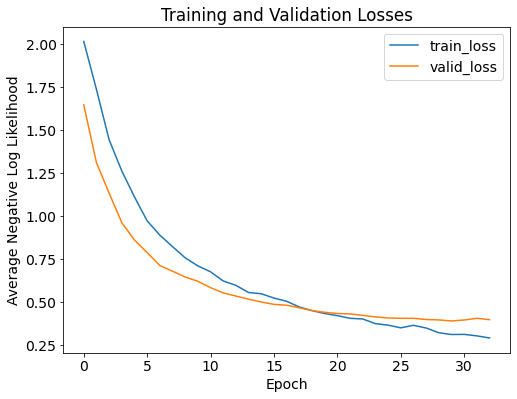

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

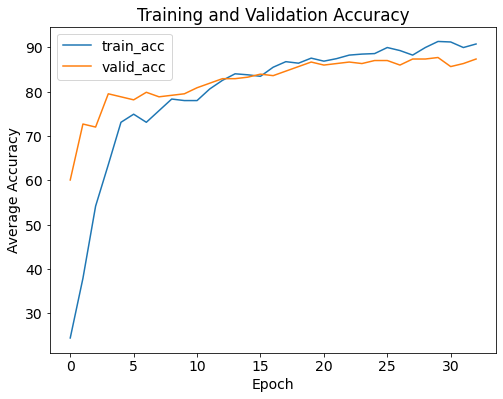

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

La fonction ci-dessous vérifie l'environnement (collab ou local) et enregistre le modèle entrainé vers l'endroit le plus pertinent. 

In [ ]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = optimizer
    checkpoint['optimizer_state_dict'] = optimizer.state_dict()

    if drive:
      print('Saving model to GDrive')
      path = DATA_PATH+path

    # Save the data to the path
    torch.save(checkpoint, path)

In [ ]:
checkpoint_path

'resnet50-transfer.pth'

In [ ]:
!ls | grep -e *.pt

resnet50-transfer.pt


In [ ]:
save_checkpoint(model, path=checkpoint_path)

Saving model to GDrive


La fonction ci-dessous effectue l'inverse de la fonction save et charge un modèle. 

In [ ]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    if drive:
      print('Loading model from GDrive')
      path = DATA_PATH+path

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [ ]:
model, optimizer = load_checkpoint(path=checkpoint_path)

Loading model from GDrive
24,034,889 total parameters.
526,857 total gradient parameters.


La fonction ci-dessous prend en entrain le chemin d'une image, la met à la bonne taille (256 pixels) et retourne son instance sous un type Tensor. 

In [ ]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [ ]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns
        
    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

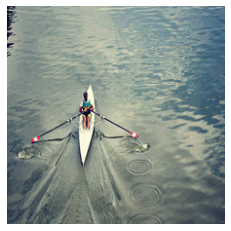

In [ ]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(categories)
    root = testdir +"/"+ c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [ ]:
img, top_p, top_classes, real_class = predict(random_test_image(), model,topk=2)

In [ ]:
top_p, top_classes, real_class

(array([0.72406965, 0.11408041], dtype=float32),
 ['ferry boat', 'freight boat'],
 'freight boat')

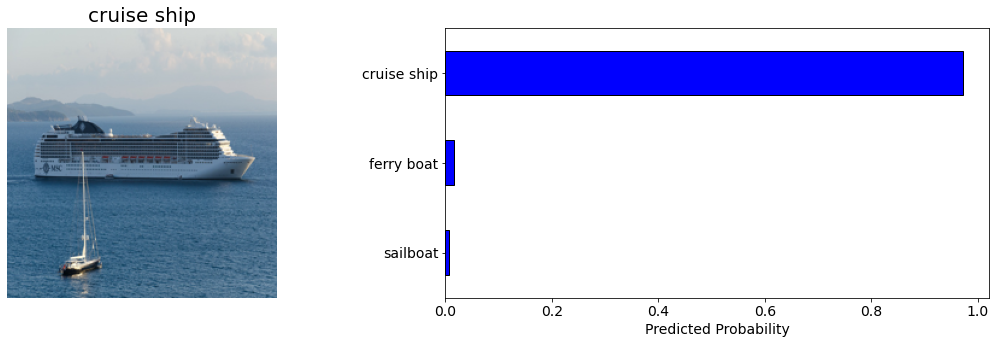

In [ ]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

display_prediction(random_test_image(), model, topk=3)

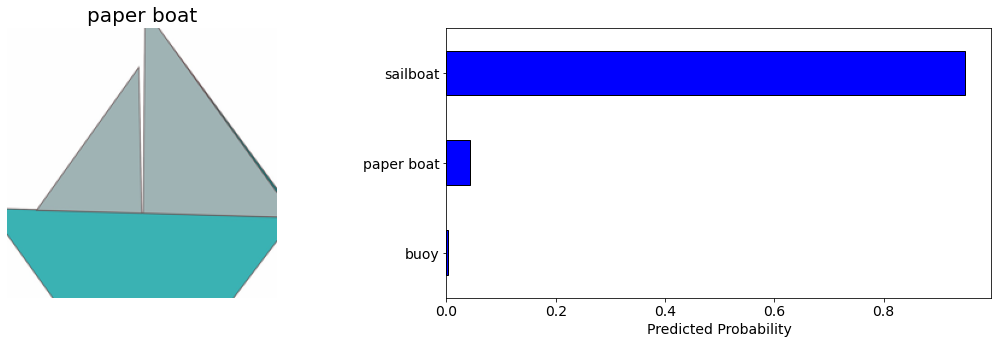

In [ ]:
display_prediction(random_test_image(), model, topk=3)

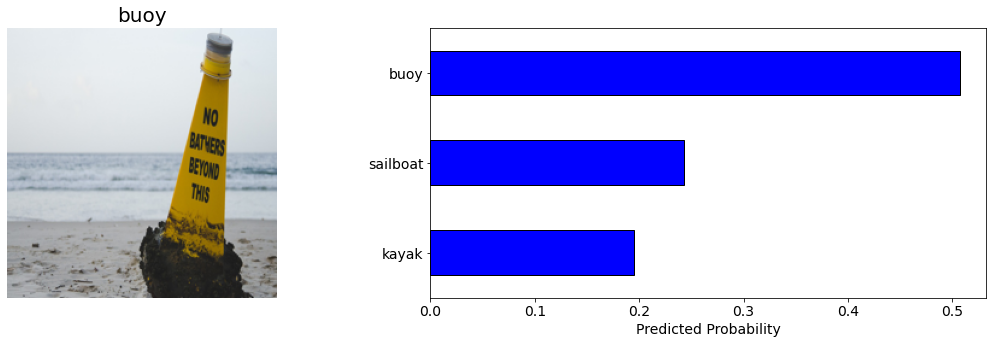

In [ ]:
display_prediction(random_test_image(), model, topk=3)

### Évaluation de la méthode

In [ ]:
# M'expliquer comment vous avez évalué votre méthode (test dataset).

In [ ]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [ ]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    res = accuracy(model(features.to('cuda')), targets, topk=(1,))
else:
    res = accuracy(model(features), targets, topk=(1,))

res

[86.3013687133789]

In [ ]:
accuracy(model(features.to('cuda')), targets, topk=(1,))

[86.3013687133789]

Confusion matrix, without normalization


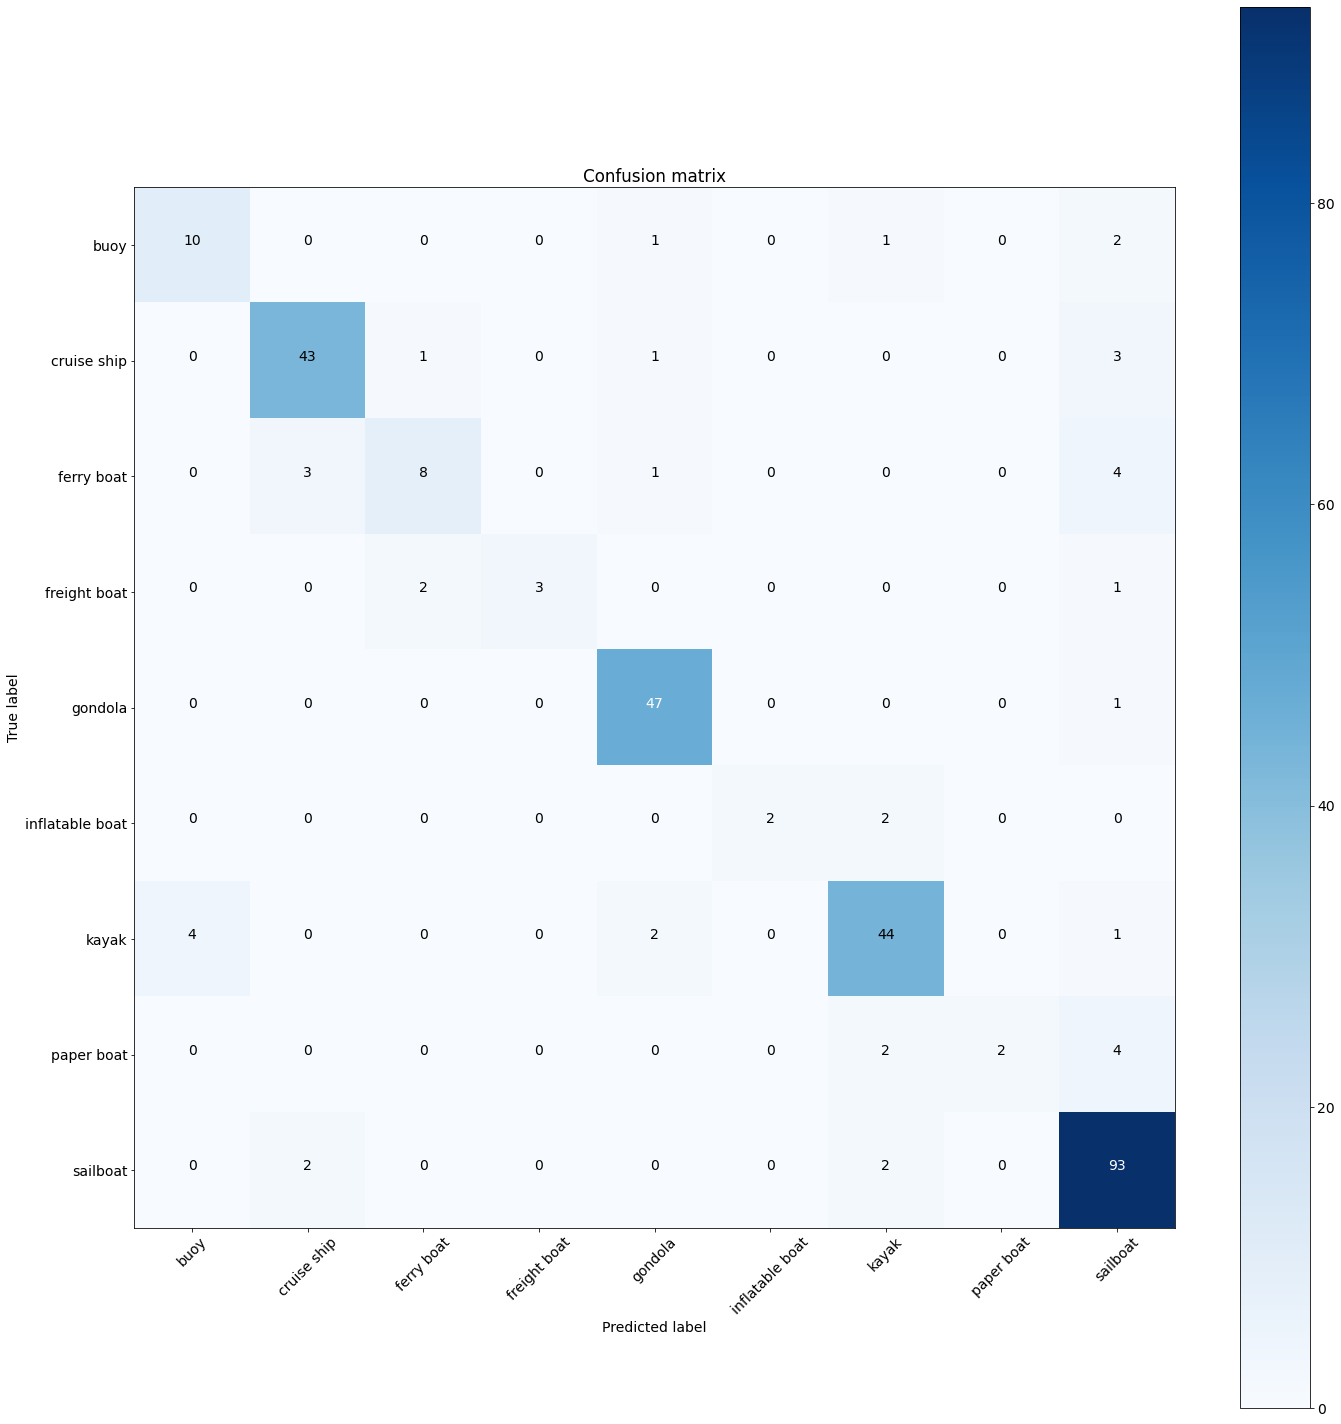

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, test_loader, criterion, topk=(1, 3, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()
    return results.reset_index().rename(columns={'index': 'class'}),confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{DATA_PATH}data/outputs/confusion_matrix.png')
    return plt


criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results, confusion_matrix = evaluate(model, dataloaders['test'], criterion)

classnames = [model.idx_to_class[i] for i in range(0,n_classes)]

plt.figure(figsize=(20,20))
plt = plot_confusion_matrix(confusion_matrix, classnames)


On peut voir les résultats de l'algorithme dans la matrice de confusion ci-dessous. Les résultats sont cohérent et il n'y a pas de résultats abérant. 